# Capstone Project - Recommendation System for a Fashion Supply Chain Marketplace

# Problem Statement

Fabric Central is a digital sourcing platform that connects apparel brands and fabric suppliers in the most efficient, accessible and transparent marketplace. Suppliers can display their materials on the platforms and Brand users can easily find the materials from various suppliers in one place. 

Fabric Central has onboarded around 78 suppliers with around 200 materials so far and has around 358 brands registered brands. However it would now like to focus on increasing their sales and engage better with their users. 

We will build a recommendation system for Fabric Central which will recommend relevant materials to the customer at various touchpoints on the platform. By showing relevant materials and helping the users fnd the right matrials for their needs, we hope to increase customer engagement and conversion rate. 

We will build two types of recommendations, 
1. Content Based
    This will recommend similar materials to the one the customer is viewing, this can be displayed on the material search page, possible under a section called "You may also like..." or "More like these..." 
2. Item based Collaborative Filtering
    This will recommend materials depending on the gabric request history of this material by other users. This can be displayed on the order confirmation page, possibly under a section called "Users who bought this also bought..."
3. Hybrid recommendations
    The fabric request data is found to be very sparse and is not available for all materials. To tackle this cold start problem, we will also provide hybrid recomendations. Here the collborative filtering related recommendations (which need fabric request data) will be generated first, and will be supplemented by the content based materials. 

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Ignoring warnings because there are some warnings related to SettingWithCopyWarning 
# inspite of using the correct code (.loc[row_indexer,col_indexer] = value)

warnings.simplefilter('ignore') 

 # 1. Read the Data from csv files

In [3]:
materials_orig = pd.read_csv("../datasets/raw_data/materials_orig.csv", encoding="ISO-8859-1")
variants_orig = pd.read_csv("../datasets/raw_data/variants_orig.csv")
tier_prices_orig = pd.read_csv("../datasets/raw_data/tier_prices_orig.csv")
suppliers_orig = pd.read_csv("../datasets/raw_data/supplier_msk_orig.csv")
fab_req_orig = pd.read_csv("../datasets/raw_data/fabric_requests_orig.csv")
users_orig = pd.read_csv("../datasets/raw_data/usrs_msk_orig.csv", encoding="ISO-8859-1")

# 2. Data Cleaning for tables related to Content Based Filtering

## 2.a. Materials Dataset

In [4]:
materials_orig.head()

,id,created_at,updated_at,code,fabric_weave,currency,supplier_id,price,name,fabric_blend_one,...,only_for_brands/13,only_for_brands/14,only_for_brands/15,only_for_brands/16,only_for_brands/17,only_for_brands/18,only_for_brands/19,only_for_brands/20,only_for_brands/21,only_for_brands/22
0,2253,2021-04-13T14:32:14.096Z,2021-07-28T08:59:59.993Z,C201069,Ripstop,EUR,23,11.90,XXXXXXXXXXganic Cotton,Organic Cotton,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,557,2020-01-30T10:24:36.482Z,2021-06-18T04:11:19.866Z,Checkered Stripes,NaN,USD,25,13.52,XXXXXXXXXXStripes TENCEL,TENCEL Lyocell,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,947,2020-06-04T14:11:02.191Z,2021-05-11T12:31:46.481Z,Low MOQ Sr 11,Plain,USD,27,1.80,XXXXXXXXXXtton (40sx40s/136x70),Organic Cotton,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2276,2021-04-30T09:47:50.602Z,2021-07-29T15:00:06.378Z,CIAO/ORG,Terry,EUR,44,15.90,XXXXXXXXXXerry Organic Cotton,Organic Cotton,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1840,2020-12-09T15:16:21.547Z,2021-06-19T04:39:06.515Z,#0014BK11B0000,NaN,USD,67,32.00,XXXXXXXXXX0000,Recycled Cow Leather,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
materials_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1954 entries, 0 to 1953
Data columns (total 83 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               1954 non-null   int64  
 1   created_at                       1954 non-null   object 
 2   updated_at                       1954 non-null   object 
 3   code                             1954 non-null   object 
 4   fabric_weave                     1081 non-null   object 
 5   currency                         1954 non-null   object 
 6   supplier_id                      1954 non-null   int64  
 7   price                            1954 non-null   float64
 8   name                             1954 non-null   object 
 9   fabric_blend_one                 1946 non-null   object 
 10  fabric_blend_one_percent         1952 non-null   float64
 11  fabric_blend_two                 760 non-null    object 
 12  fabric_blend_two_per

### Drop the materials which are unpublished, archived or don't have a price as these cannot be recommended to any users

In [6]:
# Consider only published, non-archived and materials with non-zero price
materials = materials_orig[(materials_orig['published'] == True) & 
                           (materials_orig['archived_at'].isnull()) &
                           (materials_orig['price'] > 0)
                          ]

In [7]:
materials.shape

(1546, 83)

In [8]:
materials.isnull().sum()[materials.isnull().sum() > 0]

fabric_weave                 692
fabric_blend_one               4
fabric_blend_two             958
fabric_blend_two_percent     894
fabric_blend_three          1412
                            ... 
only_for_brands/18          1543
only_for_brands/19          1545
only_for_brands/20          1545
only_for_brands/21          1545
only_for_brands/22          1545
Length: 62, dtype: int64

### Remove unnecessary columns, combine variables which were split into multiple columns due to conversion from JSON

In [9]:
# Since all values are null we will drop these columns. 
materials.drop(columns=['deleted_at', 'archived_at'], inplace=True)

In [10]:
# Function to combine columns which are split into variables which were split into multiple columns 
# Returns a new dataset with combined column and old columns dropped

def combine_columns(col_name, dataset):
    out_dataset = dataset.copy()
    cols_to_combine = []
    # Loop through all columns. 
    for col in out_dataset.columns:
        
        # If column name contains col_name followed by a "/" (usually followed by a number e.g. properties/0) , 
        # then add to the list of columns to be combined
        if col.find(col_name + '/') != -1:
            cols_to_combine.append(col)
            out_dataset[col] = out_dataset[col].str.strip()

    # Combine the listed columns into a column with col_name
    out_dataset[col_name] = out_dataset.apply(lambda x: x[cols_to_combine].dropna().to_list(), axis=1)

    # Drop old columns e.g. properties/0, properties/1 etc. 
    out_dataset.drop(columns=cols_to_combine, inplace=True)
        
    return out_dataset


In [11]:
# Combine values fro, properties/0, properties/1 etc. columns as a list into a 
# common column
materials = combine_columns('properties', materials)

In [12]:
# Separate properties with pipe separated values
def split_pipe_properties(properties):
    properties1 = properties.copy()
    for prop in properties:
        if(prop.find("|") > 0):
            lst = prop.split("|")
            [properties.append(lst_item) for lst_item in lst]
            properties.remove(prop)
    return properties

In [13]:
# Some properties values are strings with multiple properties separated by a "|" e.g. "Durable Water Repellent (DWR)|Downproof"
# These are separate properties so we separate them and add back to the list

materials['properties'] = materials['properties'].apply(lambda x: split_pipe_properties(x))

In [14]:
# Combine values fro, only_for_brands/0, only_for_brands/1 etc. columns as a list into a 
# common column

materials = combine_columns('only_for_brands', materials)

In [15]:
# Combine values fro, end_use/0, end_use/1 etc. columns as a list into a 
# common column

materials = combine_columns('end_use', materials)

In [16]:
# Some end_use values are strings with multiple end uses separated by a "|" e.g. "Casual Wear|Menswear|Performance"
# These are separate properties so we separate them and add back to the list

materials['end_use'] = materials['end_use'].apply(lambda x: split_pipe_properties(x))


### Setting the right Data Types for columns

In [17]:
materials.dtypes[0:40]

id                                   int64
created_at                          object
updated_at                          object
code                                object
fabric_weave                        object
currency                            object
supplier_id                          int64
price                              float64
name                                object
fabric_blend_one                    object
fabric_blend_one_percent           float64
fabric_blend_two                    object
fabric_blend_two_percent           float64
fabric_blend_three                  object
fabric_blend_three_percent         float64
weight                             float64
weight_unit                         object
fabric_type                         object
price_unit                          object
status                              object
published                             bool
description                         object
dispatch_time_sample                object
factory_loc

In [18]:
materials.dtypes[41:200]

properties         object
only_for_brands    object
end_use            object
dtype: object

In [19]:
# convert all date-times to datetime datatypes
materials['created_at'] = pd.to_datetime(materials['created_at'])
materials['updated_at'] = pd.to_datetime(materials['updated_at'])


### Manage null values

In [20]:
materials.isnull().sum()[materials.isnull().sum() > 0][0:40]

fabric_weave                        692
fabric_blend_one                      4
fabric_blend_two                    958
fabric_blend_two_percent            894
fabric_blend_three                 1412
fabric_blend_three_percent         1328
weight                              132
description                         277
dispatch_time_sample                 75
factory_location                      3
construction                        984
width                                88
finishing                           619
dispatch_time_mass_quantity_min     265
dispatch_time_mass_quantity_max     265
origin                             1166
colour                             1440
tsa_stamps                         1451
crowd_source_available             1200
moq_details                        1112
dtype: int64

In [21]:
# Drop materials with no factory locations
materials = materials.loc[materials['factory_location'].notnull()]

In [22]:
#  fabric_blend_one has only 6 rows with missing values, so we can drop these values
materials = materials[materials['fabric_blend_one'].notnull()]


In [23]:
# find records where fabric_blend_two which is null when fabric_blend_two_percent is not null set fabric_blend_two_percent to 0
#print(materials.loc[(materials['fabric_blend_two_percent'].notnull()) & (materials['fabric_blend_two_percent'] != 0) & (materials['fabric_blend_two'].isnull()), ['id', 'fabric_blend_two', 'fabric_blend_two_percent']])
materials.loc[(materials['fabric_blend_two'].isnull()), ['fabric_blend_two_percent']] = 0

# find records where fabric_blend_three which is null when fabric_blend_two_percent is not null, set fabric_blend_two_percent to 0
#print(materials.loc[(materials['fabric_blend_three_percent'].notnull()) & (materials['fabric_blend_three_percent'] != 0) & (materials['fabric_blend_three'].isnull()), ['id', 'fabric_blend_three', 'fabric_blend_three_percent']])
materials.loc[(materials['fabric_blend_three'].isnull()), ['fabric_blend_three_percent']] = 0


In [24]:
# fabric_blend_two and fabric_blend_three are optional fields as not all fabrics will
# have multiple blends. So we replace it with blank strings

materials['fabric_blend_two'] = materials['fabric_blend_two'].fillna("blank_blend_1")
materials['fabric_blend_three'] = materials['fabric_blend_three'].fillna("blank_blend_2")

In [25]:
# Impute values of null_column by taking mean of null_column by groupby_column
def impute_mean_by_column(dataset, null_column, groupby_column):
    # Group by the group by column and calculate mean value for null_column for each group
    grouped = dataset.groupby(groupby_column)
    transformed = grouped[null_column].mean()
    # Join the groups dataset with the materials dataset on the group_by column in order to relate 
    # the materials with the right mean value to substitute 
    dataset = dataset.merge(transformed,on=groupby_column, how="left")

    x_null_column = null_column + '_x'
    y_null_column = null_column + '_y'

    # Fill null values in the x_null_column (from the materials dataset) with the mean values in the 
    # y_null_column (from the groups dataset)
    dataset[x_null_column] = dataset[x_null_column].fillna(dataset[y_null_column])
    
    # Drop the y_null_column (originally from the groups_dataset) and 
    # rename x_null_column to original column name (null_column)
    dataset.drop([y_null_column],inplace=True,axis=1)
    dataset.rename(columns={x_null_column:null_column},inplace=True)
    return dataset


In [26]:
# Update the weight for leather materials, where the weight is null to 500
materials[materials['weight'].isnull() & materials['fabric_type'].str.contains('Leather')]['price'] = 500


In [27]:
# Update the weight for rest of the materials where the weight is 0
materials['weight'].fillna(0, inplace=True)


In [28]:
# Impute values of weight by taking mean dispatch_time_mass_quantity_min, dispatch_time_mass_quantity_max by supplier_id

materials = impute_mean_by_column(materials, 'dispatch_time_mass_quantity_min', 'supplier_id')
materials = impute_mean_by_column(materials, 'dispatch_time_mass_quantity_max', 'supplier_id')


In [29]:
# Impute values of weight by taking mean dispatch_time_mass_quantity_min by dispatch_time_sample

materials = impute_mean_by_column(materials, 'dispatch_time_mass_quantity_min', 'dispatch_time_sample')
materials = impute_mean_by_column(materials, 'dispatch_time_mass_quantity_max', 'dispatch_time_sample')


In [30]:
# Impute values of null_column by taking mean of null_column by groupby_column
def impute_mode_by_column(dataset, null_column, groupby_column):
    # Group by the group by column and calculate mean value for null_column for each group
    grouped = dataset.groupby(groupby_column)
    transformed = grouped[null_column].agg(pd.Series.mode)
    #transformed[transformed.str.len == 0, 'supplier_id'] = ""
    
    # Join the groups dataset with the materials dataset on the group_by column in order to relate 
    # the materials with the right mean value to substitute 
    dataset = dataset.merge(transformed,on=groupby_column, how="left")

    x_null_column = null_column + '_x'
    y_null_column = null_column + '_y'

    # Fill null values in the x_null_column (from the materials dataset) with the mean values in the 
    # y_null_column (from the groups dataset)
    dataset[x_null_column] = dataset[x_null_column].fillna(dataset[y_null_column])
    
    # Drop the y_null_column (originally from the groups_dataset) and 
    # rename x_null_column to original column name (null_column)
    dataset.drop([y_null_column],inplace=True,axis=1)
    dataset.rename(columns={x_null_column:null_column},inplace=True)
    
    # Set empty lists to null (mode returns an empty list when there are no values found in the group)
    dataset.loc[dataset[null_column].str.len() == 0, [null_column]] = np.nan    
    
    return dataset

In [31]:
# Impute dispatch_time_sample by finding the mode (most occurring value for the given supplier)
materials = impute_mode_by_column(materials, 'dispatch_time_sample', 'supplier_id')


In [32]:
# Impute dispatch_time_sample by finding the mode (most occurring value for the given factory location)
materials = impute_mode_by_column(materials, 'dispatch_time_sample', 'factory_location')


In [33]:
# Replace the rest of the null values with "blank_display_sample" text
materials['dispatch_time_sample'].fillna("blank_display_sample", inplace=True)

In [34]:
# Impute the null values of width by taking mean width by fabric_blend_one

materials = impute_mean_by_column(materials, 'width', 'fabric_blend_one')

In [35]:
# Impute the remaining null values of width by taking mean width by fabric_weave

materials = impute_mean_by_column(materials, 'width', 'fabric_weave')

In [36]:
# Impute the null values of width_unit by taking mode width by fabric_blend_one

materials = impute_mode_by_column(materials, 'width_unit', 'fabric_blend_one')

In [37]:
#  We replace null fabric weaves with blank
materials['fabric_weave'].fillna("blank_weave", inplace=True)

In [38]:
# Only 1 null weight unit found so we update it to the most common weight unit 
materials.loc[materials['weight_unit'].isnull(), 'weight_unit'] = materials.loc[materials['weight_unit'].notnull(), 'weight_unit'][0]

In [39]:
materials.isnull().sum()[materials.isnull().sum() > 0][0:40]

description                277
construction               980
width                       72
finishing                  615
origin                    1162
colour                    1433
tsa_stamps                1444
crowd_source_available    1199
moq_details               1109
dtype: int64

In [40]:
# Impute the null values of desicription as "blank_description"

materials['description'].fillna("blank_description", inplace=True)

In [41]:
# Impute the null values of desicription as "blank_finishing"

materials['finishing'].fillna("blank_finishing", inplace=True)

In [42]:
# For columns with too many nulls, and not relevant we drop them from materials dataset
# Keep only relevant columns in the material dataset

materials.drop(columns=['construction', 'origin', 'colour', 'tsa_stamps', 'crowd_source_available', 'moq_details'], inplace=True)

In [43]:
materials.shape

(1539, 38)

## 2b. Supplier Dataset

We use this dataset to get information about suppliers to see if there can be relevant information which can be used to recomemnd materials to users

In [44]:
suppliers_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      78 non-null     int64  
 1   name                    78 non-null     object 
 2   fabric_factory_country  0 non-null      float64
 3   dyeing_factory_country  0 non-null      float64
 4   created_at              78 non-null     object 
 5   updated_at              78 non-null     object 
 6   website                 78 non-null     object 
 7   fabric_type             33 non-null     object 
 8   specialty               30 non-null     object 
 9   end_uses                20 non-null     object 
 10  fibers                  33 non-null     object 
 11  status                  78 non-null     object 
 12  deleted_at              28 non-null     object 
 13  years_of_work           3 non-null      float64
 14  origin                  17 non-null     obje

In [45]:
# Replace null fabric_type, specialty, end_uses, fibers. 
# These values are specific to suppliers and cannot be imputed as per the domain experts. 
# It may not be possible to use the supplier data for recommendations for this reason
# However, for now we will still go ahead with it.

suppliers = suppliers_orig[['id', 'name', 'fabric_type', 'specialty', 'end_uses', 'fibers']]
suppliers['fabric_type'].fillna('blank_fabrictype', inplace=True)
suppliers['specialty'].fillna('blank_specialty', inplace=True)
suppliers['end_uses'].fillna('blank_end_uses', inplace=True)
suppliers['fibers'].fillna('blank_fibers', inplace=True)


In [46]:
suppliers.rename(columns={'name': 'supp_name', 'id': 'supplier_id', 'fabric_type': 'supp_fabric_type', 'specialty': 'supp_specialty', 'end_uses': 'supp_end_uses', 'fibers': 'supp_fibers'}, inplace=True)


Since there are many null values in the suppliers dataset features, we will not be able to use it for recommendations. However we will still merge it with materials dataset, for future use. 


## 2c. Material Tier Price Dataset

This dataset stores tiered pricing for bulk orders. We will examine it to see if there is relevant information to be used. 

In [47]:
tier_prices_orig.head()

,id,material_id,starts_from,price,created_at,updated_at
0,3049,2426,60,21.50,2021-07-27T17:01:40.734Z,2021-07-27T17:01:40.734Z
1,3197,2132,31,9.79,2021-07-29T15:04:05.979Z,2021-07-29T15:04:05.979Z
2,7,376,100,3.50,2021-04-16T05:27:29.967Z,2021-04-16T05:27:29.967Z
3,8,376,1000,3.00,2021-04-16T05:27:29.970Z,2021-04-16T05:27:29.970Z
4,9,667,300,2.00,2021-04-16T05:27:29.997Z,2021-04-16T05:27:29.997Z


In [48]:
materials.shape

(1539, 38)

In [49]:
tier_prices_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           429 non-null    int64  
 1   material_id  429 non-null    int64  
 2   starts_from  429 non-null    int64  
 3   price        429 non-null    float64
 4   created_at   429 non-null    object 
 5   updated_at   429 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 20.2+ KB


In [50]:
# We drop the created_at, updated_at fields as they are not relevant to the analysis
tier_prices = tier_prices_orig[['id', 'material_id', 'starts_from', 'price']]


In [51]:
# Rename the 'price' and 'id' columns so there is no conflict while merging with the materials dataset
# Rename rest of the columns to align with the materials dataset

tier_prices.rename(columns={'starts_from': 'tiered_price_starts_from','price':'tiered_price', 'id':'tier_price_id', 'material_id':'id'}, inplace=True)


In [52]:
tier_prices.head()

,tier_price_id,id,tiered_price_starts_from,tiered_price
0,3049,2426,60,21.50
1,3197,2132,31,9.79
2,7,376,100,3.50
3,8,376,1000,3.00
4,9,667,300,2.00


## 2d. Material Variants Dataset

This dataset stores data about colour variants of the materials. 

In [53]:
variants_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2832 entries, 0 to 2831
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           2832 non-null   int64  
 1   colour_name  791 non-null    object 
 2   pantone      134 non-null    object 
 3   hex          134 non-null    object 
 4   material_id  2832 non-null   int64  
 5   created_at   2832 non-null   object 
 6   updated_at   2832 non-null   object 
 7   deleted_at   0 non-null      float64
 8   image        543 non-null    object 
 9   leftover     1876 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 221.4+ KB


In [54]:
variants_orig.shape

(2832, 10)

In [55]:
variants_orig.dtypes

id               int64
colour_name     object
pantone         object
hex             object
material_id      int64
created_at      object
updated_at      object
deleted_at     float64
image           object
leftover       float64
dtype: object

In [56]:
variants_orig.isnull().sum()

id                0
colour_name    2041
pantone        2698
hex            2698
material_id       0
created_at        0
updated_at        0
deleted_at     2832
image          2289
leftover        956
dtype: int64

In [57]:
# Drop deleted_at column as all values are null
# Drop created_at, updated_at, image columns as they are not relevant for our analysis
# leftover column is also dropped as it is a legacy field, no longer in use
variants = variants_orig[['id', 'colour_name', 'pantone', 'hex', 'material_id']]


In [58]:
variants.shape

(2832, 5)

In [59]:
# Take only those rows for which either colour name, pantone or hex values are not null
variants = variants[(variants['colour_name'].notnull()) | (variants['pantone'].notnull()) | (variants['hex'].notnull())]


In [60]:
# Rename id and material_id columns to align the column names with the materials dataset
variants.rename(columns={'id': 'variant_id', 'colour_name':'var_colour', 'pantone':'var_pantone', 'hex':'var_hex'}, inplace=True)


In [61]:
variants.head()

,variant_id,var_colour,var_pantone,var_hex,material_id
94,259,007642,NaN,NaN,493
95,254,007577,NaN,NaN,488
103,1862,Black Beauty,19-3911,26262a,391
109,200,Orange,NaN,NaN,278
185,361,000615,NaN,NaN,652


## 2c. Merge Materials, Supplier datasets

In [62]:
materials.shape

(1539, 38)

In [63]:
materials = materials.merge(suppliers, on='supplier_id', how='left')


In [64]:
materials.head()

,id,created_at,updated_at,code,fabric_weave,currency,supplier_id,price,name,fabric_blend_one,...,swatch_price,swatch_quantity,properties,only_for_brands,end_use,supp_name,supp_fabric_type,supp_specialty,supp_end_uses,supp_fibers
0,2253,2021-04-13 14:32:14.096000+00:00,2021-07-28 08:59:59.993000+00:00,C201069,Ripstop,EUR,23,11.90,XXXXXXXXXXganic Cotton,Organic Cotton,...,2,4.0,[],[],"[Coat, Jacket, Pants]",XXXXXXXXXX,TECHNICAL AND OUTWEAR FABRICS,blank_specialty,MEDIUM HIGH LUXURY BRANDS,"Cotton, Polyamide (Nylon) ,Polyester, Wool, SE,LI"
1,557,2020-01-30 10:24:36.482000+00:00,2021-06-18 04:11:19.866000+00:00,Checkered Stripes,blank_weave,USD,25,13.52,XXXXXXXXXXStripes TENCEL,TENCEL Lyocell,...,2,0.0,[],[],"[Dress, Pants, Skirt]",XXXXXXXXXX,blank_fabrictype,"Wovens, small order",blank_end_uses,blank_fibers
2,947,2020-06-04 14:11:02.191000+00:00,2021-05-11 12:31:46.481000+00:00,Low MOQ Sr 11,Plain,USD,27,1.80,XXXXXXXXXXtton (40sx40s/136x70),Organic Cotton,...,2,3.0,[],[],[Shirt],XXXXXXXXXXics,Woven and Knits,blank_specialty,"Mens Wear, Women's wear, OOTD",Organic natural fibres
3,2276,2021-04-30 09:47:50.602000+00:00,2021-07-29 15:00:06.378000+00:00,CIAO/ORG,Terry,EUR,44,15.90,XXXXXXXXXXerry Organic Cotton,Organic Cotton,...,2,36.0,[],[],"[Sweatshirt, Leggings / Yoga Pants, Blouse, Tr...",XXXXXXXXXX,Knit,Recycled Natural Fibre,blank_end_uses,"Recycled Wool, Recycled Cotton"
4,1840,2020-12-09 15:16:21.547000+00:00,2021-06-19 04:39:06.515000+00:00,#0014BK11B0000,blank_weave,USD,67,32.00,XXXXXXXXXX0000,Recycled Cow Leather,...,2,0.0,[],[Archive],"[Bags & Wallets, Shoes]",XXXXXXXXXXher,Others,Sustainable Leather,"Accessories, Leather Goods, Luxury, New Innova...",Leather / Skin


## 2d. Merge Material, Tier_prices and Variants datasets

In [65]:
materials.shape

(1539, 43)

In [66]:
# Merge the relevant fields from the tier_prices table with materials table
materials_tiered_prices = materials.merge(tier_prices[['id','tiered_price_starts_from','tiered_price']], on='id', how='left')


In [67]:
materials_tiered_prices.columns

Index(['id', 'created_at', 'updated_at', 'code', 'fabric_weave', 'currency',
       'supplier_id', 'price', 'name', 'fabric_blend_one',
       'fabric_blend_one_percent', 'fabric_blend_two',
       'fabric_blend_two_percent', 'fabric_blend_three',
       'fabric_blend_three_percent', 'weight', 'weight_unit', 'fabric_type',
       'price_unit', 'status', 'published', 'description',
       'dispatch_time_sample', 'factory_location', 'width', 'width_unit',
       'finishing', 'dispatch_time_mass_quantity_min',
       'dispatch_time_mass_quantity_max', 'minimal_order_quantity', 'uuid',
       'notify_fc_team', 'moq', 'swatch_price', 'swatch_quantity',
       'properties', 'only_for_brands', 'end_use', 'supp_name',
       'supp_fabric_type', 'supp_specialty', 'supp_end_uses', 'supp_fibers',
       'tiered_price_starts_from', 'tiered_price'],
      dtype='object')

In [68]:
# Merge the relevant fields from the variants dataset with materials dataset
materials_merged = materials_tiered_prices.merge(variants[['material_id','var_colour','var_pantone', 'var_hex']], left_on='id', right_on='material_id', how='left')
materials_merged.drop(columns=['material_id'], inplace=True)

In [69]:
materials_merged.shape

(2400, 48)

In [70]:
# replace null values in colour_name, pantone and hex with blanks
materials_merged['var_colour'].fillna("blank_colour", inplace=True)
materials_merged['var_pantone'].fillna("blank_pantone", inplace=True)
materials_merged['var_hex'].fillna("blank_hex", inplace=True)


In [71]:
materials_merged.isnull().sum()

id                                    0
created_at                            0
updated_at                            0
code                                  0
fabric_weave                          0
currency                              0
supplier_id                           0
price                                 0
name                                  0
fabric_blend_one                      0
fabric_blend_one_percent              0
fabric_blend_two                      0
fabric_blend_two_percent              0
fabric_blend_three                    0
fabric_blend_three_percent            0
weight                                0
weight_unit                           0
fabric_type                           0
price_unit                            0
status                                0
published                             0
description                           0
dispatch_time_sample                  0
factory_location                      0
width                                72


In [72]:
materials_merged.loc[materials_merged['tiered_price_starts_from'].isnull(), ['tiered_price_starts_from', 'tiered_price', 'price', 'minimal_order_quantity']]


,tiered_price_starts_from,tiered_price,price,minimal_order_quantity
0,NaN,NaN,11.9,0.0
1,NaN,NaN,11.9,0.0
2,NaN,NaN,11.9,0.0
3,NaN,NaN,11.9,0.0
4,NaN,NaN,11.9,0.0
...,...,...,...,...
2395,NaN,NaN,170.0,1.0
2396,NaN,NaN,252.0,1.0
2397,NaN,NaN,10.3,5000.0
2398,NaN,NaN,3.5,3000.0


In [73]:
materials_merged["var_colour"].value_counts()

blank_colour    1507
000615            22
000001            14
Natural           12
White             11
                ... 
006926             1
17                 1
Greige             1
007309             1
Olive Green        1
Name: var_colour, Length: 478, dtype: int64

### Impute fields that are null after merging

In [74]:
# Impute the tiered price to same as sample price and update tiered_price_starts_from to moq
materials_merged.loc[materials_merged['tiered_price'].isnull(), ['tiered_price']] = materials_merged['price']
materials_merged.loc[materials_merged['tiered_price_starts_from'].isnull(), ['tiered_price_starts_from']] = materials_merged['minimal_order_quantity']

# Impute the tiered price to same as sample price and update tiered_price_starts_from to moq
materials_tiered_prices.loc[materials_tiered_prices['tiered_price'].isnull(), ['tiered_price']] = materials_tiered_prices['price']
materials_tiered_prices.loc[materials_tiered_prices['tiered_price_starts_from'].isnull(), ['tiered_price_starts_from']] = materials_tiered_prices['minimal_order_quantity']


After merging we oberve that most (over 1000) tier price and variant colours are blank, so we will not focus on these tables. 

We will focus our EDA on the materials table

# 3. EDA for tables related to Content Based filtering

In [75]:
#Plot the countplot for column, sorted by descending order of counts 
def sorted_count_plot(dataset, column, blank_value="", title="", x_label="", y_label=""):
    plt.figure(figsize=(12,14))
    
    # If blank_value is passed then exclude blank values and print the count
    if blank_value != "":
        print(f"Blank values: {len(dataset[dataset[column] == blank_value])}")
        dataset = dataset[dataset[column] != blank_value]

    sort_order = dataset.groupby(column)["id"].count().sort_values(ascending=False).index.values
    hp = sns.countplot(data=dataset, y=column, order=sort_order);

    if(title == ""):
        hp.set_title(f"Distribution of materials by {column}", fontsize=22);
        hp.set_xlabel("Count", fontsize=20);
        hp.set_ylabel(column, fontsize=20);
    else:
        hp.set_title(title, fontsize=22);
        hp.set_xlabel(x_label, fontsize=20);
        hp.set_ylabel(y_label, fontsize=20);
    return hp

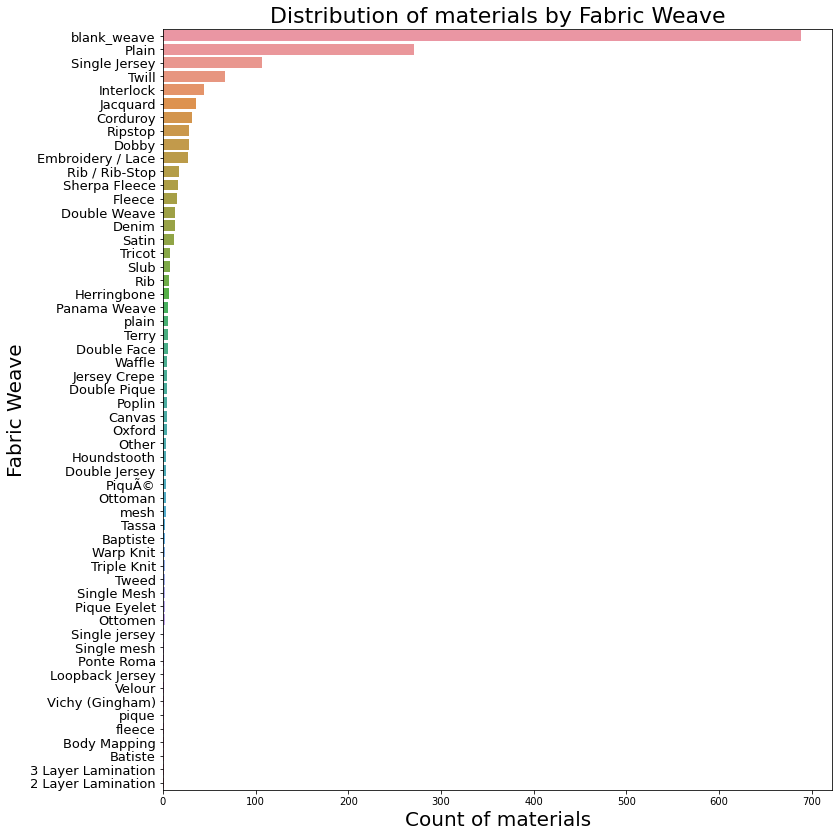

In [76]:
# Plot the distribution for fabric_weave

cp = sorted_count_plot(materials, "fabric_weave", title="Distribution of materials by Fabric Weave", y_label="Fabric Weave", x_label="Count of materials")
cp.set_yticklabels(cp.get_ymajorticklabels(), fontsize = 13);

Maximum fabrics have blank fabric_weave (688), followed by plain (280). However, this is an important feature to identify the right fabrics, so we may still use it. 

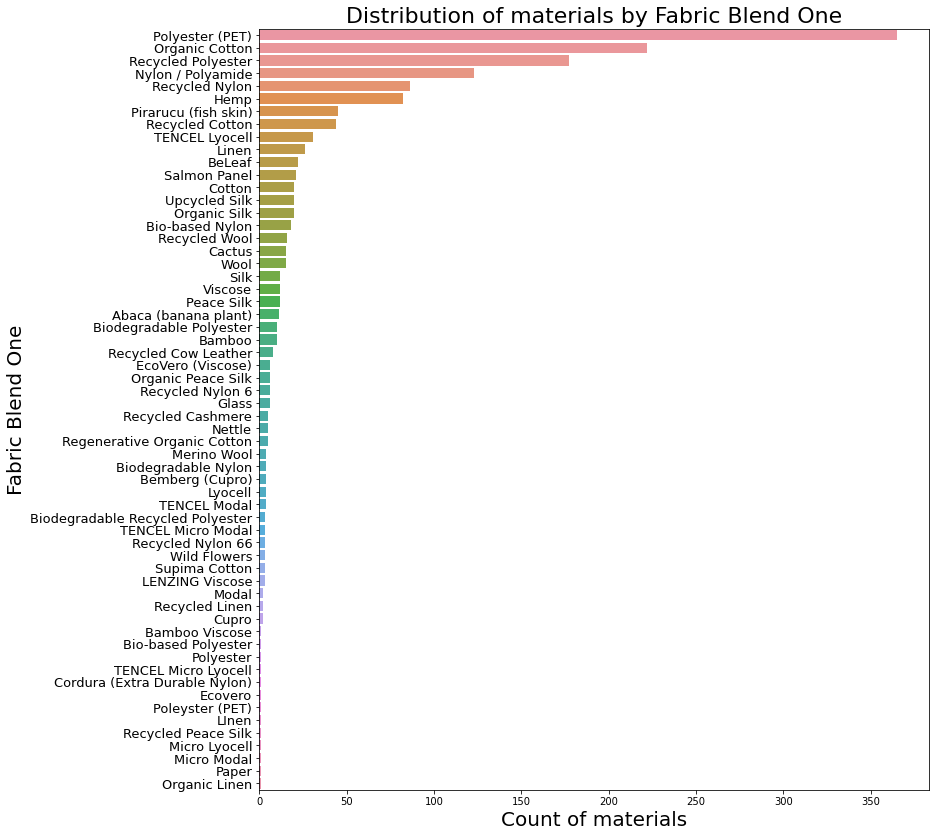

In [77]:
# Plot the distribution for fabric_blend_one

cp = sorted_count_plot(materials, "fabric_blend_one", title="Distribution of materials by Fabric Blend One", y_label="Fabric Blend One", x_label="Count of materials")
cp.set_yticklabels(cp.get_ymajorticklabels(), fontsize = 13);

This is an important field for content based recommendations, as per domain experts. Also has very few blank valyues which were dropped. We will include these in the content based recommendation model.

<AxesSubplot:title={'center':'Distribution of materials by supplier_id'}, xlabel='Count', ylabel='supplier_id'>

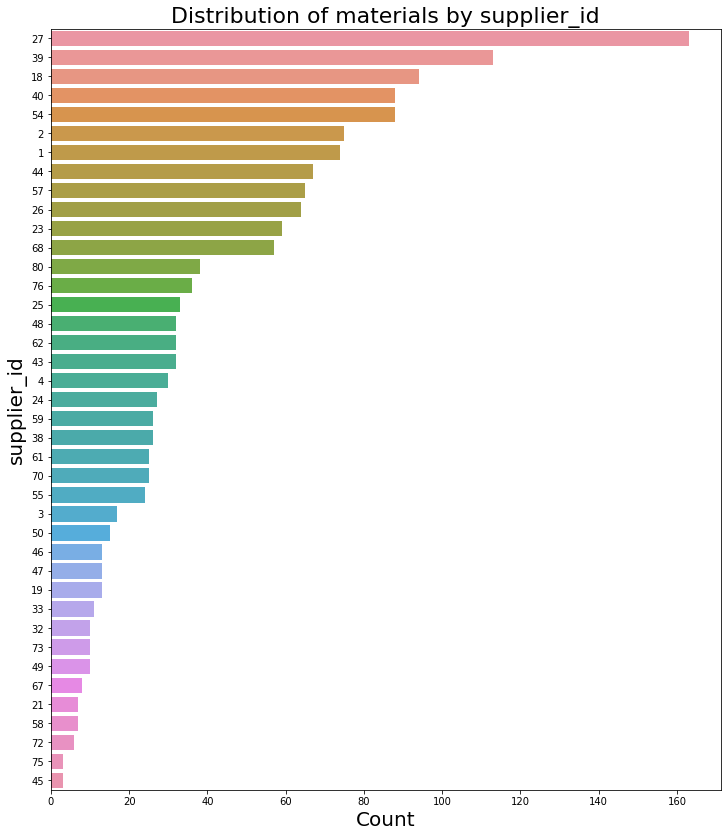

In [78]:
# Plot the distribution for supplier_id

sorted_count_plot(materials, "supplier_id")

In [79]:
materials['supplier_id'].value_counts().count()

40

All the materials belong to 40 unique suppliers. This is an important field for content based recommendations, as per domain experts. Also has very no blank values. We will include these in the content based recommendation model.

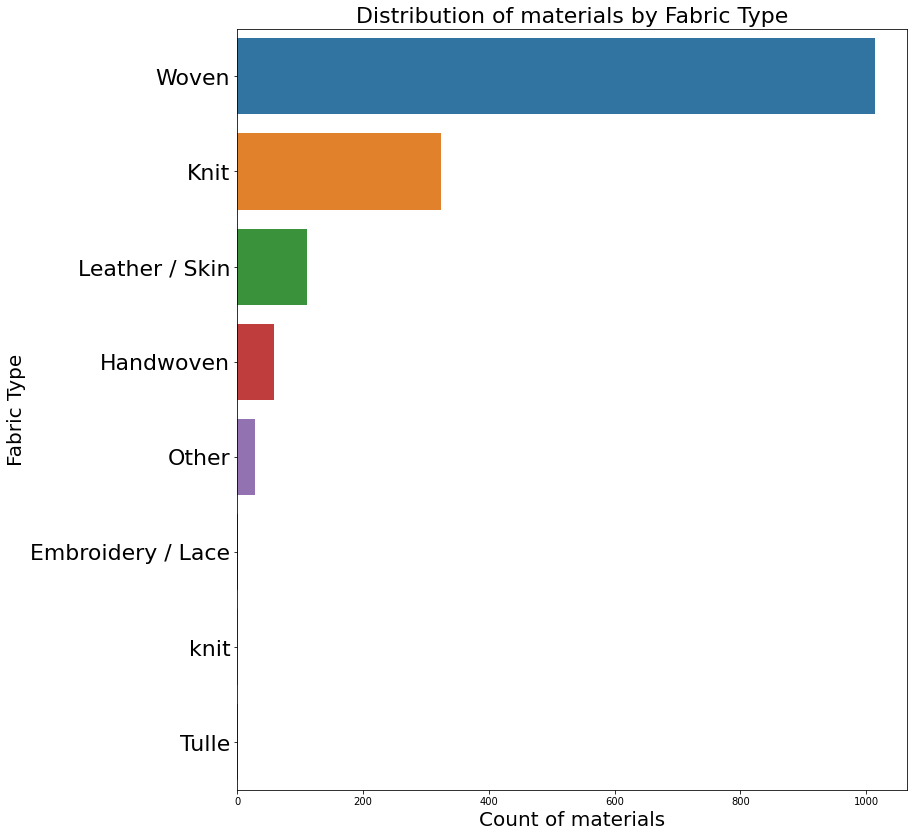

In [80]:
# Plot the histogram for fabric_type
cp = sorted_count_plot(materials, "fabric_type", title="Distribution of materials by Fabric Type", y_label="Fabric Type", x_label="Count of materials")
cp.set_yticklabels(cp.get_ymajorticklabels(), fontsize = 22);


This is a broad classification but an important one, as per domain experts and will help to avoid incorrect recommendations due to end_use. We will include these in the content based recommendation model. No blank values.

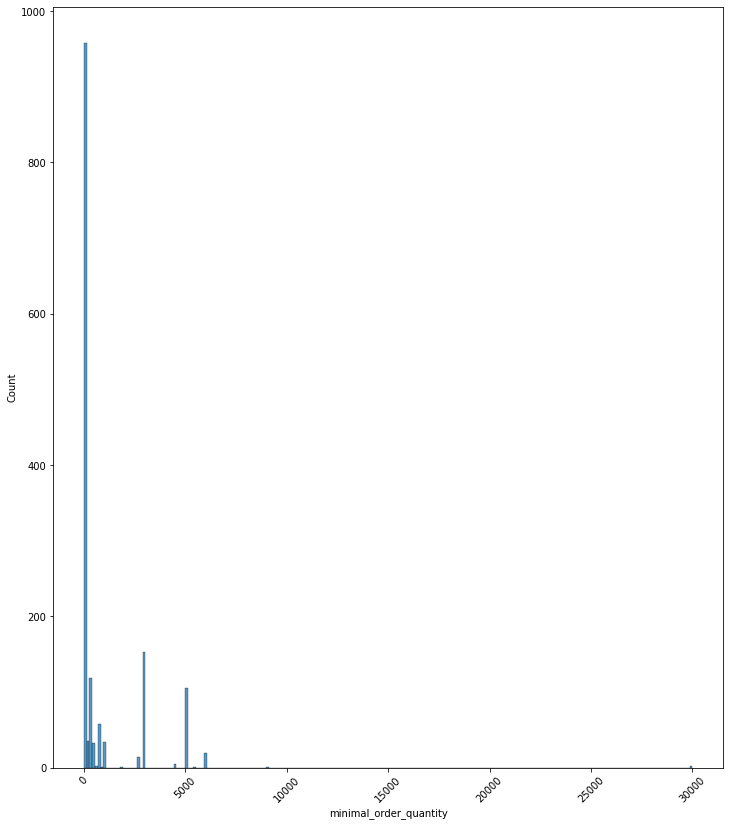

In [81]:
# Plot the histogram for minimal_order_quantity
plt.figure(figsize=(12,14))
hp = sns.histplot(data=materials, x='minimal_order_quantity')
plt.xticks(rotation=45);


Specifies minimal order quantity for orders. It's not the very relevant for recommendations and most materials have zero minimal order quantity, hence this field will not be useful for recommendations. 

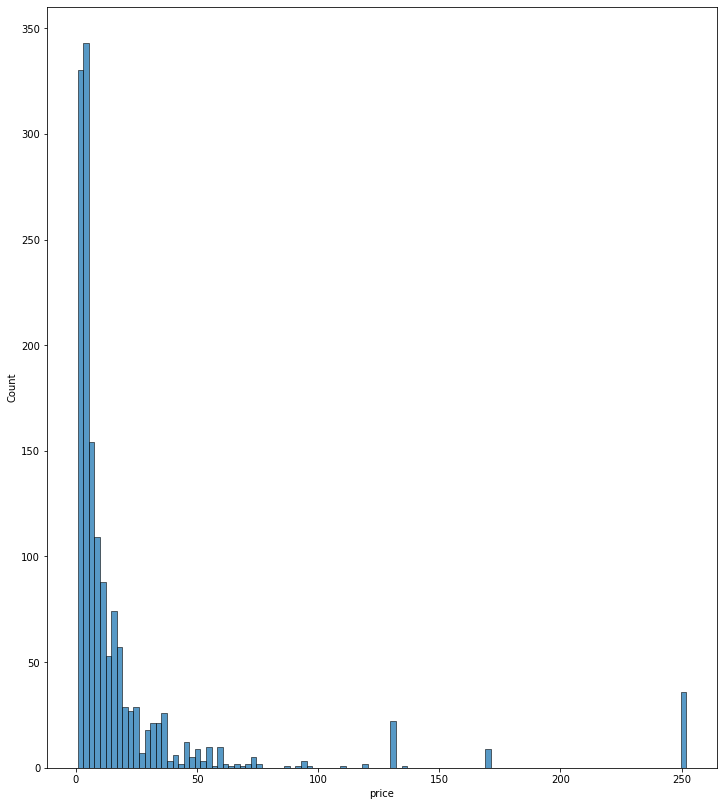

In [82]:
# Plot the histogram for price
import matplotlib.ticker as ticker

plt.figure(figsize=(12,14))
cp = sns.histplot(data=materials[materials['price']!= 0], x='price')

In [83]:
materials[(materials['price'] >  200)] 

,id,created_at,updated_at,code,fabric_weave,currency,supplier_id,price,name,fabric_blend_one,...,swatch_price,swatch_quantity,properties,only_for_brands,end_use,supp_name,supp_fabric_type,supp_specialty,supp_end_uses,supp_fibers
31,2464,2021-06-17 05:47:30.903000+00:00,2021-07-27 14:40:53.370000+00:00,Pirarucu LR Woo Drost Matte,blank_weave,EUR,54,252.0,XXXXXXXXXXRARUCU WILD LR Woo Drost Matte,Pirarucu (fish skin),...,2,0.0,[],[],"[Bags & Wallets, Caps & Hats, Shoes, Jacket, P...",XXXXXXXXXXu,Leather / Plant leaf,Sustainable Leather,Garments/ Accessories/ Upholst,blank_fibers
104,1364,2020-07-26 21:49:34.363000+00:00,2021-07-27 14:40:53.277000+00:00,ORGANIC PIRARUCU WILD LL MATTE BISCUIT,blank_weave,EUR,54,252.0,XXXXXXXXXXRARUCU WILD LL MATTE BISCUIT,Pirarucu (fish skin),...,2,0.0,[],[],"[Bags & Wallets, Caps & Hats, Shoes, Jacket, P...",XXXXXXXXXXu,Leather / Plant leaf,Sustainable Leather,Garments/ Accessories/ Upholst,blank_fibers
106,1366,2020-07-26 21:49:34.391000+00:00,2021-07-27 14:40:53.291000+00:00,ORGANIC PIRARUCU WILD LL MATTE WHITE,blank_weave,EUR,54,252.0,XXXXXXXXXXRARUCU WILD LL MATTE WHITE,Pirarucu (fish skin),...,2,0.0,[],[],"[Bags & Wallets, Caps & Hats, Shoes, Jacket, P...",XXXXXXXXXXu,Leather / Plant leaf,Sustainable Leather,Garments/ Accessories/ Upholst,blank_fibers
107,1353,2020-07-26 21:49:34.209000+00:00,2021-07-27 14:40:53.304000+00:00,ORGANIC PIRARUCU WILD LL SHINY CHESNUT,blank_weave,EUR,54,252.0,XXXXXXXXXXRARUCU WILD LL SHINY CHESNUT,Pirarucu (fish skin),...,2,0.0,[],[],"[Bags & Wallets, Caps & Hats, Shoes, Jacket, P...",XXXXXXXXXXu,Leather / Plant leaf,Sustainable Leather,Garments/ Accessories/ Upholst,blank_fibers
108,1352,2020-07-26 21:49:34.194000+00:00,2021-07-27 14:40:53.318000+00:00,ORGANIC PIRARUCU WILD LL SHINY HIGH RISK RED,blank_weave,EUR,54,252.0,XXXXXXXXXXRARUCU WILD LL SHINY HIGH RISK RED,Pirarucu (fish skin),...,2,0.0,[],[],"[Bags & Wallets, Caps & Hats, Shoes, Jacket, P...",XXXXXXXXXXu,Leather / Plant leaf,Sustainable Leather,Garments/ Accessories/ Upholst,blank_fibers
109,1359,2020-07-26 21:49:34.294000+00:00,2021-07-27 14:40:53.331000+00:00,ORGANIC PIRARUCU WILD LL SHINY SEPIA,blank_weave,EUR,54,252.0,XXXXXXXXXXRARUCU WILD LL SHINY SEPIA,Pirarucu (fish skin),...,2,0.0,[],[],"[Bags & Wallets, Caps & Hats, Shoes, Jacket, P...",XXXXXXXXXXu,Leather / Plant leaf,Sustainable Leather,Garments/ Accessories/ Upholst,blank_fibers
110,1379,2020-07-26 21:49:34.573000+00:00,2021-07-27 14:40:53.344000+00:00,ORGANIC PIRARUCU WILD LL ULTRA SHINY BLUE POWDER,blank_weave,EUR,54,252.0,XXXXXXXXXXRARUCU WILD LL ULTRA SHINY BLUE POWDER,Pirarucu (fish skin),...,2,0.0,[],[],"[Bags & Wallets, Caps & Hats, Shoes, Jacket, P...",XXXXXXXXXXu,Leather / Plant leaf,Sustainable Leather,Garments/ Accessories/ Upholst,blank_fibers
114,1380,2020-07-26 21:49:34.587000+00:00,2021-07-27 14:40:53.398000+00:00,ORGANIC PIRARUCU WILD LL FINISHING 2 BLACK,blank_weave,EUR,54,252.0,XXXXXXXXXXRARUCU WILD LL FINISHING 2 BLACK,Pirarucu (fish skin),...,2,0.0,[],[],"[Bags & Wallets, Caps & Hats, Shoes, Jacket, P...",XXXXXXXXXXu,Leather / Plant leaf,Sustainable Leather,Garments/ Accessories/ Upholst,blank_fibers
125,1367,2020-07-26 21:49:34.406000+00:00,2021-07-27 14:40:53.507000+00:00,ORGANIC PIRARUCU WILD LL MATTE GARGOYLE,blank_weave,EUR,54,252.0,XXXXXXXXXXRARUCU WILD LL MATTE GARGOYLE,Pirarucu (fish skin),...,2,0.0,[],[],"[Bags & Wallets, Caps & Hats, Shoes, Jacket, P...",XXXXXXXXXXu,Leather / Plant leaf,Sustainable Leather,Garments/ Accessories/ Upholst,blank_fibers
126,1354,2020-07-26 21:49:34.223000+00:00,2021-07-27 14:40:53.519000+00:00,ORGANIC PIRARUCU WILD LL SHINY SILVER,blank_weave,EUR,54,252.0,XXXXXXXXXXRARUCU WILD LL SHINY SILVER,Pirarucu (fish skin),...,2,0.0,[],[],"[Bags & Wallets, Caps & Hats, Shoes, Jacket, P...",XXXXXXXXXXu,Leather / Plant leaf,Sustainable Leather,Garments/ Accessories/ Upholst,blank_fibers


Price will be an important field for recomemnndations. Most materials have prices under 50\\$ per meter square. There is a set of materials containing Pirarucu (fish skin) from a supplier (52) which are around 250\\$ per meter square,  hence we see a spike at 250\\$ in the histogram. It is observed that some suppliers (52, 54) have high end fabrics. 

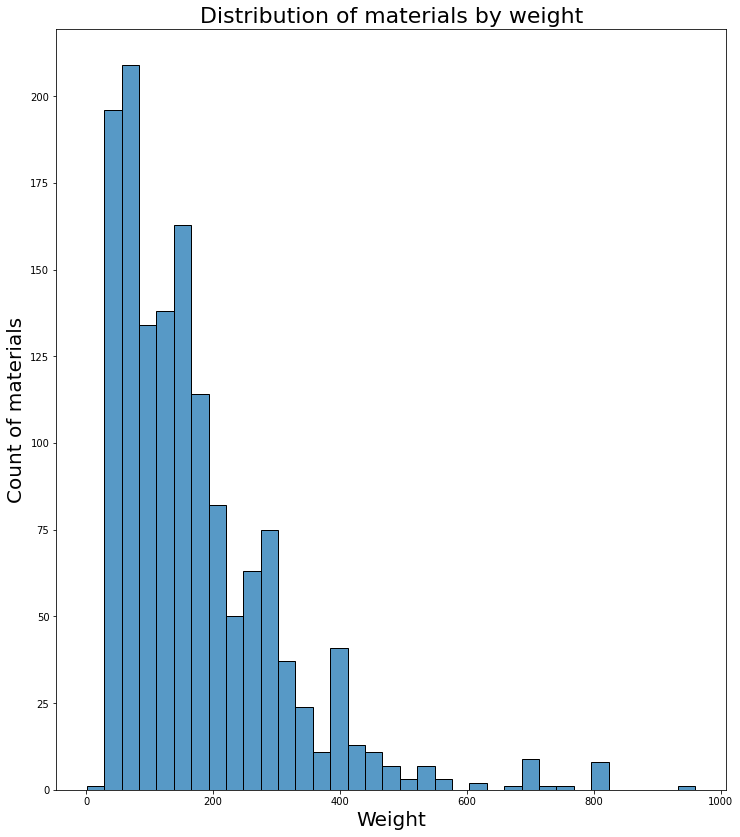

In [84]:
# Plot the histogram for price
import matplotlib.ticker as ticker

plt.figure(figsize=(12,14))
cp = sns.histplot(data=materials[materials['weight']!= 0], x='weight')

cp.set_title(f"Distribution of materials by weight", fontsize=22);
cp.set_xlabel("Weight", fontsize=20);
cp.set_ylabel("Count of materials", fontsize=20);



Weight is a n important factor when predicting recommendations as designers often look for specific weight of fabrics when ordering. Most fabrics have non zero weights, making it a good factor for prediction. 

For Content Based recommendations we find that the materials dataset has some useful features which will be used for recommendations such as weight, price, fabric_blend_one, fabric_type etc. 

# 4. Data cleaning of tables related to Collaborative Filtering

## 4a. Fabric Requests Dataset

Fabric request dataset includes fabric requests made by brand users. Fabric requests are the first step of an order. Only once the supplier confirms availability the user can place an order. However the fabric requests are stilla good indicator of user's interest in the fabric. 

In [85]:
fab_req_orig.head()

,id,status,type,quantity,requested_at,closed_at,delay_days,delay_note,material_id,user_id,...,order_id,price,price_unit,surcharge,accepted_at,deleted_at,origin_quantity,variant_id,currency,bought_price
0,1008,delayed,swatch,1.0,2020-11-02T15:54:30.176Z,2021-05-26T06:41:30.280Z,5.0,"Swatch is only available in 1 colour, but we c...",734,311,...,NaN,0.00,NaN,NaN,2020-11-03T21:24:54.864Z,NaN,NaN,409,NaN,NaN
1,1692,delivered,swatch,1.0,2021-04-29T16:17:53.656Z,NaN,NaN,NaN,842,284,...,234.0,2.00,NaN,NaN,NaN,NaN,NaN,461,USD,2.00
2,1699,delivered,swatch,1.0,2021-04-29T16:17:53.656Z,NaN,NaN,NaN,2130,284,...,234.0,2.00,NaN,NaN,NaN,NaN,NaN,2158,USD,2.00
3,272,delayed,sample,10.0,2020-06-01T04:47:47.012Z,2020-06-01T05:09:14.777Z,14.0,NaN,198,7,...,NaN,9.20,NaN,20.0,NaN,NaN,NaN,153,NaN,0.00
4,30,delivered,sample,3.0,2019-10-23T15:00:20.698Z,NaN,NaN,NaN,500,69,...,72.0,20.57,NaN,NaN,NaN,NaN,NaN,266,USD,61.71


In [86]:
fab_req_orig.shape

(1062, 23)

In [87]:
fab_req_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1062 entries, 0 to 1061
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1062 non-null   int64  
 1   status           1062 non-null   object 
 2   type             1062 non-null   object 
 3   quantity         1062 non-null   float64
 4   requested_at     919 non-null    object 
 5   closed_at        278 non-null    object 
 6   delay_days       304 non-null    float64
 7   delay_note       138 non-null    object 
 8   material_id      1062 non-null   int64  
 9   user_id          1062 non-null   int64  
 10  project_id       73 non-null     float64
 11  created_at       1062 non-null   object 
 12  updated_at       1062 non-null   object 
 13  order_id         605 non-null    float64
 14  price            1062 non-null   float64
 15  price_unit       73 non-null     object 
 16  surcharge        45 non-null     float64
 17  accepted_at   

In [88]:
# convert all date-times to datetime datatypes
fab_req_orig['requested_at'] = pd.to_datetime(fab_req_orig['requested_at'])
fab_req_orig['closed_at'] = pd.to_datetime(fab_req_orig['closed_at'])
fab_req_orig['created_at'] = pd.to_datetime(fab_req_orig['created_at'])
fab_req_orig['updated_at'] = pd.to_datetime(fab_req_orig['updated_at'])
fab_req_orig['accepted_at'] = pd.to_datetime(fab_req_orig['accepted_at'])
fab_req_orig['deleted_at'] = pd.to_datetime(fab_req_orig['deleted_at'])


In [89]:
fab_req_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1062 entries, 0 to 1061
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   id               1062 non-null   int64              
 1   status           1062 non-null   object             
 2   type             1062 non-null   object             
 3   quantity         1062 non-null   float64            
 4   requested_at     919 non-null    datetime64[ns, UTC]
 5   closed_at        278 non-null    datetime64[ns, UTC]
 6   delay_days       304 non-null    float64            
 7   delay_note       138 non-null    object             
 8   material_id      1062 non-null   int64              
 9   user_id          1062 non-null   int64              
 10  project_id       73 non-null     float64            
 11  created_at       1062 non-null   datetime64[ns, UTC]
 12  updated_at       1062 non-null   datetime64[ns, UTC]
 13  order_id         6

As we are interested only in the information about which user has requested fabrics, we drop the other fields

In [90]:
fab_requests = fab_req_orig.drop(columns=["requested_at","closed_at", "delay_days", 
                                          "delay_note", "project_id", "created_at",
                                         "updated_at","order_id", "price",  "price_unit",
                                          "surcharge", "accepted_at", "deleted_at", 
                                          "origin_quantity", "variant_id", "currency",
                                          "bought_price"
                                         ])

In [91]:
fab_requests.isnull().sum()

id             0
status         0
type           0
quantity       0
material_id    0
user_id        0
dtype: int64

## 4b. Users Dataset

Contains information about users of the FC system.

In [92]:
users_orig.head()

,Id,Email,Name,Remember me token,Remember me token expires at,Activation state,Activation token,Activation token expires at,Reset password token,Reset password token expires at,Reset password email sent at,Role,Created at,Updated at,Deleted at,Origin,Phone,Last login at,Currency
0,624,XXXXXXXya@XXXXX.co,XXXXXXXa,NaN,NaN,active,NaN,NaN,NaN,NaN,NaN,admin,2021-09-02 06:59:58 UTC,2021-09-02 07:02:19 UTC,NaN,Google,NaN,2021-09-02 07:02:19 UTC,USD
1,623,XXXXXXXrkowski@XXXXXumbers.eu,XXXXXXX Gmurkowski,NaN,NaN,active,NaN,NaN,NaN,NaN,NaN,admin,2021-09-01 18:43:23 UTC,2021-09-01 18:43:43 UTC,NaN,Google,NaN,NaN,USD
2,622,XXXXXXXa@XXXXXexfabrics.com,XXXXXXX Zaldumbide,NaN,NaN,active,NaN,NaN,Yt_84C9wFcuBXa46ssdV,2021-09-02 11:14:03 UTC,2021-09-01 11:14:03 UTC,product_user,2021-09-01 11:14:03 UTC,2021-09-01 11:14:03 UTC,NaN,NaN,NaN,NaN,USD
3,621,XXXXXXXXXXXXlgreen.solutions,XXXXXXXn Drunen,NaN,NaN,active,NaN,NaN,dRRP-o__5JStk41dJf5H,2021-08-26 08:57:31 UTC,2021-08-25 08:57:31 UTC,product_user,2021-08-25 08:57:31 UTC,2021-08-25 08:57:31 UTC,NaN,NaN,NaN,NaN,EUR
4,620,XXXXXXXrt+test10@demo.solutions,XXXXXXX,NaN,NaN,active,NaN,NaN,NaN,NaN,NaN,admin,2021-08-24 11:35:16 UTC,2021-08-24 12:35:41 UTC,2021-08-24 12:35:41 UTC,Google,NaN,NaN,USD


In [93]:
# Rename column names to replace spaces with "_", and change to lower case
def fix_col_name (col_name):
    col_name = col_name.replace(" ", "_")
    col_name = col_name.lower()
    return col_name

users = users_orig.rename(columns = {orig_name: fix_col_name(orig_name) for orig_name in users_orig.columns})


In [94]:
users.head()

,id,email,name,remember_me_token,remember_me_token_expires_at,activation_state,activation_token,activation_token_expires_at,reset_password_token,reset_password_token_expires_at,reset_password_email_sent_at,role,created_at,updated_at,deleted_at,origin,phone,last_login_at,currency
0,624,XXXXXXXya@XXXXX.co,XXXXXXXa,NaN,NaN,active,NaN,NaN,NaN,NaN,NaN,admin,2021-09-02 06:59:58 UTC,2021-09-02 07:02:19 UTC,NaN,Google,NaN,2021-09-02 07:02:19 UTC,USD
1,623,XXXXXXXrkowski@XXXXXumbers.eu,XXXXXXX Gmurkowski,NaN,NaN,active,NaN,NaN,NaN,NaN,NaN,admin,2021-09-01 18:43:23 UTC,2021-09-01 18:43:43 UTC,NaN,Google,NaN,NaN,USD
2,622,XXXXXXXa@XXXXXexfabrics.com,XXXXXXX Zaldumbide,NaN,NaN,active,NaN,NaN,Yt_84C9wFcuBXa46ssdV,2021-09-02 11:14:03 UTC,2021-09-01 11:14:03 UTC,product_user,2021-09-01 11:14:03 UTC,2021-09-01 11:14:03 UTC,NaN,NaN,NaN,NaN,USD
3,621,XXXXXXXXXXXXlgreen.solutions,XXXXXXXn Drunen,NaN,NaN,active,NaN,NaN,dRRP-o__5JStk41dJf5H,2021-08-26 08:57:31 UTC,2021-08-25 08:57:31 UTC,product_user,2021-08-25 08:57:31 UTC,2021-08-25 08:57:31 UTC,NaN,NaN,NaN,NaN,EUR
4,620,XXXXXXXrt+test10@demo.solutions,XXXXXXX,NaN,NaN,active,NaN,NaN,NaN,NaN,NaN,admin,2021-08-24 11:35:16 UTC,2021-08-24 12:35:41 UTC,2021-08-24 12:35:41 UTC,Google,NaN,NaN,USD


We only need this dataset to filter out demo users. So we only keep the necessary columns

In [95]:
users = users[["id", "email", "name", "activation_state", "role"]]

In [96]:
# Rename "id" to "user_id" to avoid ambiguity after merging with the fabric_requests dataset
users = users.rename(columns={"email":"user_email", "id":"user_id", "name":"user_name", "activation_state":"user_activation_state", "role":"user_role"})

## 4c. Merge Fabric Request and Users datasets

In [97]:
fab_requests = fab_requests.merge(users, how="left", on="user_id")

In [98]:
fab_requests.head()

,id,status,type,quantity,material_id,user_id,user_email,user_name,user_activation_state,user_role
0,1008,delayed,swatch,1.0,734,311,XXXXXXXct@XXXXXelier.com,XXXXXXXa Ponce de LeÃ³n,active,admin
1,1692,delivered,swatch,1.0,842,284,XXXXXXXbeth@XXXXXnnectingthread.com,XXXXXXXeth Bijaoui,active,admin
2,1699,delivered,swatch,1.0,2130,284,XXXXXXXbeth@XXXXXnnectingthread.com,XXXXXXXeth Bijaoui,active,admin
3,272,delayed,sample,10.0,198,7,XXXXXXXrt@demo.solutions,XXXXXXX,active,admin
4,30,delivered,sample,3.0,500,69,XXXXXXXa@demo.com.tw,XXXXXXX Chou,active,admin


## 4d. Merge Fabric Request and Materials datasets

We merge the fabric request and materials datasets to get material names, and to remove fabric requests for any deleted materials.

In [99]:
fab_requests = fab_requests.merge(materials[["id", "name"]], how="inner", left_on="material_id", right_on="id", suffixes=[None, "_y"])
fab_requests.drop(columns=["id_y"], inplace=True)
fab_requests.rename(columns={"name":"material_name"}, inplace=True)

In [100]:
fab_requests.head()

,id,status,type,quantity,material_id,user_id,user_email,user_name,user_activation_state,user_role,material_name
0,1008,delayed,swatch,1.0,734,311,XXXXXXXct@XXXXXelier.com,XXXXXXXa Ponce de LeÃ³n,active,admin,XXXXXXXXXX4 ORG: Waterproof Organic Cotton 200...
1,1611,delivered,swatch,1.0,734,168,XXXXXXXhaylovast@XXXXX.com,XXXXXXX,active,admin,XXXXXXXXXX4 ORG: Waterproof Organic Cotton 200...
2,1871,delivered,swatch,1.0,734,168,XXXXXXXhaylovast@XXXXX.com,XXXXXXX,active,admin,XXXXXXXXXX4 ORG: Waterproof Organic Cotton 200...
3,1875,delivered,swatch,1.0,734,168,XXXXXXXhaylovast@XXXXX.com,XXXXXXX,active,admin,XXXXXXXXXX4 ORG: Waterproof Organic Cotton 200...
4,1874,delivered,swatch,1.0,734,168,XXXXXXXhaylovast@XXXXX.com,XXXXXXX,active,admin,XXXXXXXXXX4 ORG: Waterproof Organic Cotton 200...


### Drop demo user ids from fabric requests

Remove the demo email ids, as they have requested on behalf of other offline users and this can skew the recommendations. These ids have been marked with  "@demo." in the email id. 

In [101]:
# Remove all fabric requests with email ids which contain demo accounts
fab_requests = fab_requests[(fab_requests["user_email"].str.contains("@demo.") == False)]


In [102]:
fab_requests.shape

(751, 11)

In [103]:
fab_requests.groupby(by="material_name").count()["id"]

material_name
XXXXXXXXXX                                         29
XXXXXXXXXX / BLACK                                  3
XXXXXXXXXX 3 Layer Plain Nylon                      1
XXXXXXXXXX BEIGE FANTASY                            4
XXXXXXXXXX Canvas Lyocell/Linen 290 gsm             3
                                                   ..
XXXXXXXXXX® All Black - uncoated                    2
XXXXXXXXXX® Classic Navy - natural wax coating      1
XXXXXXXXXX® Limestone - natural wax coating         2
XXXXXXXXXX® Natural White - natural wax coating     3
XXXXXXXXXX® Natural White - uncoated                5
Name: id, Length: 305, dtype: int64

## 5. EDA of tables related to Collaborative Filtering

Text(0, 0.5, 'Count of Fabric Requests')

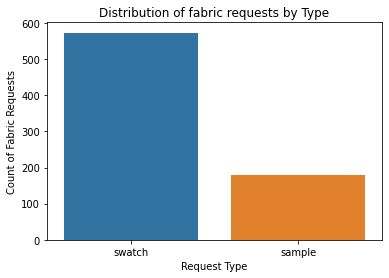

In [104]:
# Distribution of fabric requests by type
cp = sns.countplot(data=fab_requests, x='type')
cp.set_title("Distribution of fabric requests by Type")
cp.set_xlabel("Request Type")
cp.set_ylabel("Count of Fabric Requests")



There are two types of fabric requests, swatch and sample. Swatch is a small piece of fabric used only checking the type of fabric.  Many more swatch requests are observed. Swatches are free, so we will need to give more weightage to sample requests.

Text(0, 0.5, 'Count of Fabric Requests')

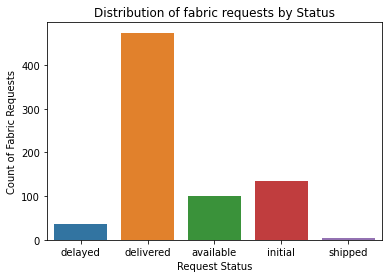

In [105]:
# Distribution of fabric requests by status
cp = sns.countplot(data=fab_requests, x='status')
cp.set_title("Distribution of fabric requests by Status")
cp.set_xlabel("Request Status")
cp.set_ylabel("Count of Fabric Requests")


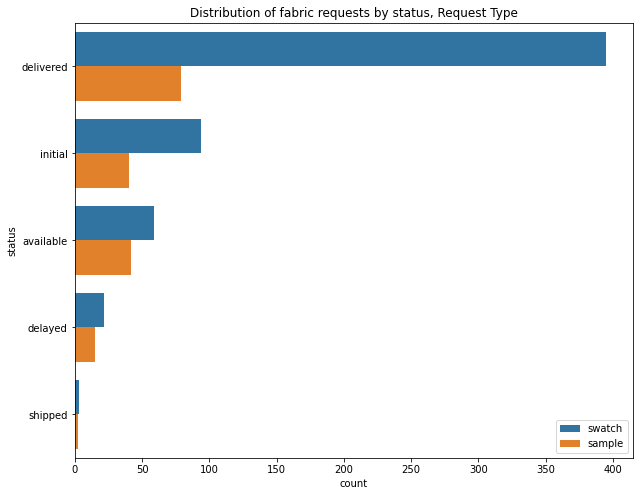

In [106]:
# Plot distribution of fabric requests by status, type
plt.figure(figsize=(10,8))

cp = sns.countplot(data=fab_requests, y="status", hue="type", order=fab_requests.status.value_counts().index)
cp.set_title("Distribution of fabric requests by status, Request Type")
plt.legend(loc='lower right')


Since there is no cancelled status included in the data we will include all fabric requests for purposes of recommendations. 

In [107]:
len(fab_requests.user_id.value_counts())

69

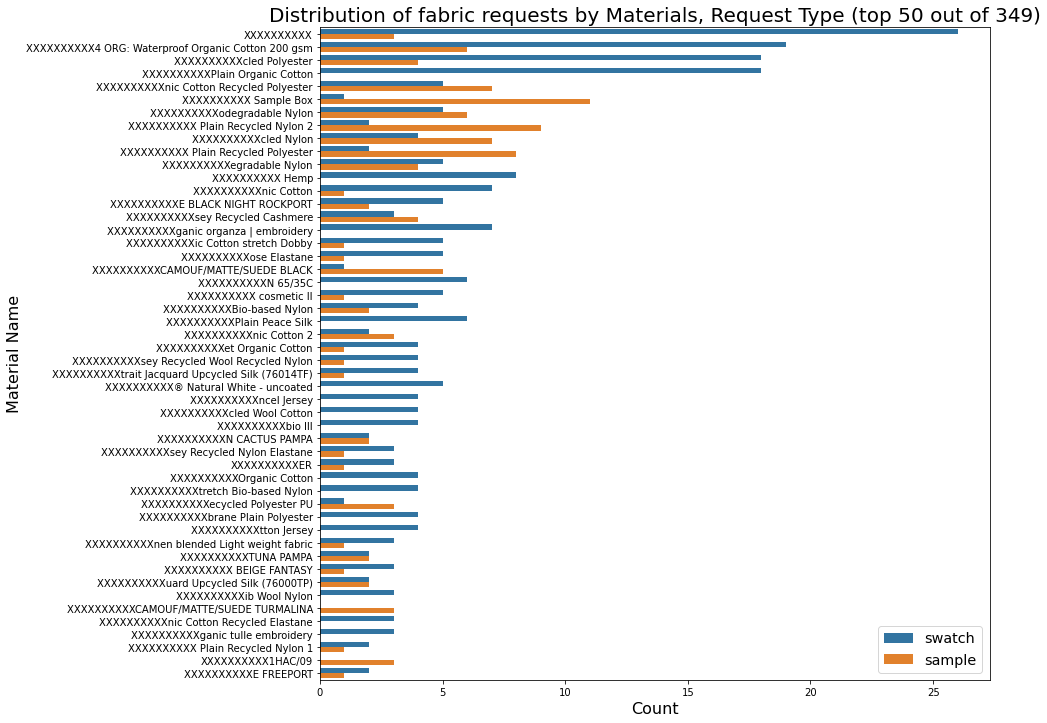

In [108]:
# Plot Distribution of fabric requests by Materials, Request type
plt.figure(figsize=(12,12))

cp = sns.countplot(data=fab_requests, y="material_name", hue="type", order=fab_requests.material_name.value_counts().iloc[:50].index)
cp.set_title("Distribution of fabric requests by Materials, Request Type (top 50 out of 349)", fontsize=20)
cp.set_xlabel("Count", fontsize=16)
cp.set_ylabel("Material Name", fontsize=16)
plt.legend(loc='lower right', fontsize='x-large')



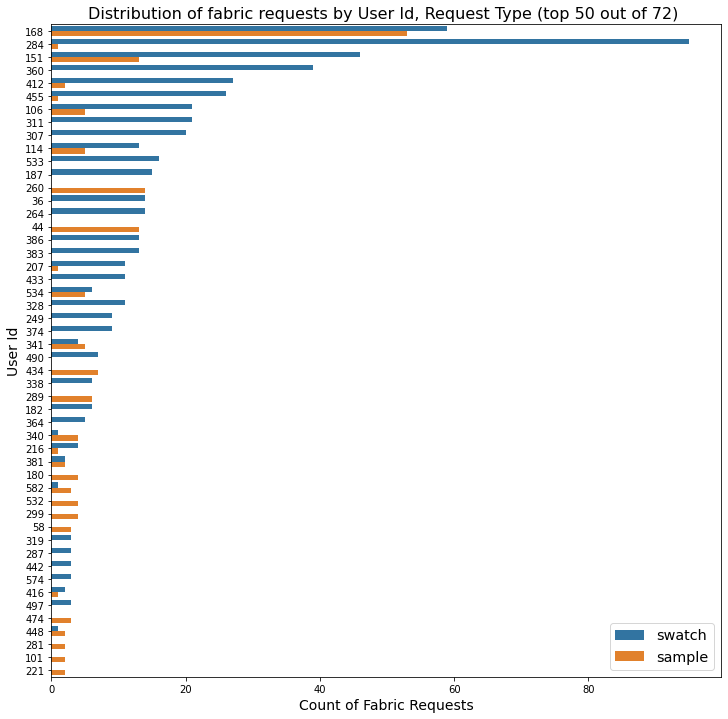

In [109]:
# Plot distribution of fabric requests by user id, request type
plt.figure(figsize=(12,12))

cp = sns.countplot(data=fab_requests, y="user_id", hue="type", order=fab_requests.user_id.value_counts().iloc[:50].index)
cp.set_title("Distribution of fabric requests by User Id, Request Type (top 50 out of 72) ", fontsize=16)
cp.set_xlabel("Count of Fabric Requests", fontsize=14)
cp.set_ylabel("User Id", fontsize=14)
plt.legend(loc='lower right', fontsize='x-large')



It is observed that user_id 284 has requested many more swatches (100) compared to actual samples (under 5). This may not be a serious user. So we remove this user from the dataset. 

In [110]:
fab_requests = fab_requests[fab_requests["user_id"] != 284]

# Save Datasets to files

In [111]:
materials.to_csv('../datasets/clean_data/materials_clean.csv', index=False)
variants.to_csv('../datasets/clean_data/variants_clean.csv', index=False)
tier_prices.to_csv('../datasets/clean_data/tiered_price_clean.csv', index=False)
materials_merged.to_csv('../datasets/clean_data/materials_merged.csv', index=False)
fab_requests.to_csv('../datasets/clean_data/fabric_requests_clean.csv', index=False)
materials_tiered_prices.to_csv('../datasets/clean_data/materials_tiered_prices.csv', index=False)